In [1]:
# ============================================
# Load python scripts
# ============================================
import sys
sys.path.append('/kaggle/input/meansparse')
import Meansparse_wrn_94_16

In [2]:
# ============================================
# Install dependencies
# ============================================
!pip install -q gdown torchsummary huggingface_hub

In [15]:
# ============================================
# Import libraries
# ============================================
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset, Subset, WeightedRandomSampler
from torchsummary import summary
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from PIL import ImageFile
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import gc
from huggingface_hub import HfApi, login, create_repo, hf_hub_download
from kaggle_secrets import UserSecretsClient
import Meansparse_wrn_94_16
from Meansparse_wrn_94_16 import MeanSparse_DMWideResNet

In [4]:
os.makedirs("/kaggle/working/xAI", exist_ok=True)
%cd /kaggle/working/xAI

/kaggle/working/xAI


In [5]:
# ============================================
# Download pretrained checkpoint
# ============================================
file_id = "1-GoAnBP6K6uwAzJbe4liOSfN_sZVYTln"
checkpoint_path = "/kaggle/working/xAI/Bartoldson2024Adversarial_WRN-94-16_WS.pt"

# Download from Google Drive to your Drive
!gdown {file_id} -O {checkpoint_path}

print("✅ Checkpoint downloaded at:", checkpoint_path)

Downloading...
From (original): https://drive.google.com/uc?id=1-GoAnBP6K6uwAzJbe4liOSfN_sZVYTln
From (redirected): https://drive.google.com/uc?id=1-GoAnBP6K6uwAzJbe4liOSfN_sZVYTln&confirm=t&uuid=1476aff4-9645-4153-857a-59f21ab6bfd9
To: /kaggle/working/xAI/Bartoldson2024Adversarial_WRN-94-16_WS.pt
100%|███████████████████████████████████████| 1.47G/1.47G [00:05<00:00, 279MB/s]
✅ Checkpoint downloaded at: /kaggle/working/xAI/Bartoldson2024Adversarial_WRN-94-16_WS.pt


In [29]:
# ---------------------------
# Setup
# ---------------------------
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)

data_root = "/kaggle/input/fracatlas"
write_dir = "/kaggle/working/fracatlas"

class_names = ["fractured", "not fractured"]

In [6]:
# ---------------------------
# Collect fractured + non-fractured images
# ---------------------------
# Fractured: train + test dirs combined
fractured_imgs = []
for subdir in ["train", "test", "val"]:
    img_dir = os.path.join(data_root, subdir, "img")
    if os.path.exists(img_dir):
        fractured_imgs.extend([os.path.join(img_dir, x) for x in os.listdir(img_dir)])

# Non-fractured
nonfractured_imgs = [os.path.join(data_root, "not fractured", "img", x)
                     for x in os.listdir(os.path.join(data_root, "not fractured", "img"))]

print(f"Total fractured images: {len(fractured_imgs)}")
print(f"Total non-fractured images: {len(nonfractured_imgs)}")

Total fractured images: 717
Total non-fractured images: 3366


In [7]:
# ---------------------------
# Optional Undersampling (to balance a bit)
# ---------------------------
# Reduce number of non-fractured samples
target_nonfractured = 1500
if len(nonfractured_imgs) > target_nonfractured:
    nonfractured_imgs = random.sample(nonfractured_imgs, target_nonfractured)
print(f"Using {len(nonfractured_imgs)} non-fractured images after undersampling.")

Using 1500 non-fractured images after undersampling.


In [8]:
# ---------------------------
# Reorganize into ImageFolder format
# ---------------------------
# Structure after this step:
#   write_dir/
#       fractured/
#       not fractured/
shutil.rmtree(write_dir, ignore_errors=True)
os.makedirs(os.path.join(write_dir, "fractured"), exist_ok=True)
os.makedirs(os.path.join(write_dir, "not fractured"), exist_ok=True)

# Copy fractured
for img in fractured_imgs:
    shutil.copy(img, os.path.join(write_dir, "fractured"))

# Copy non-fractured
for img in nonfractured_imgs:
    shutil.copy(img, os.path.join(write_dir, "not fractured"))

In [9]:
# ---------------------------
# Transforms
# ---------------------------
# Standard normalization
normalize_transform = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2470, 0.2435, 0.2616]
)

# Stronger augmentation for fractured samples
fracture_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_transform
])

# Regular transform (for all images)
base_aug = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_transform
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize_transform
])

In [10]:
# ---------------------------
# Custom Dataset Wrapper to Apply Class-Specific Augmentations
# ---------------------------
class AugmentedImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            # Apply stronger augmentation for fractured (class 1)
            if target == 1:
                sample = fracture_aug(sample)
            else:
                sample = base_aug(sample)
        return sample, target

In [30]:
# ---------------------------
# Dataset Creation
# ---------------------------
full_dataset = AugmentedImageFolder(root=write_dir, transform=None)
print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

# ---------------------------
# Stratified Train/Val/Test Split (80/10/10)
# ---------------------------
all_indices = list(range(len(full_dataset)))
all_labels = [full_dataset.samples[i][1] for i in all_indices]

# First split: Train (80%) vs Temp (20%)
train_idx, temp_idx, y_train, y_temp = train_test_split(
    all_indices, all_labels, stratify=all_labels, test_size=0.2, random_state=20
)

# Second split: Val (10%) vs Test (10%) from Temp
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, stratify=y_temp, test_size=0.5, random_state=20
)

# Subset datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Assign transforms
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# ---------------------------
# Weighted Sampling (Oversampling)
# ---------------------------
targets = [full_dataset.samples[i][1] for i in train_dataset.indices]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Classes: ['fractured', 'not fractured']
Total images: 2217


In [31]:
# ---------------------------
# DataLoaders
# ---------------------------
batch_size = 1
ImageFile.LOAD_TRUNCATED_IMAGES = True

dl_train = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0)
dl_val   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 1773, Val: 222, Test: 222


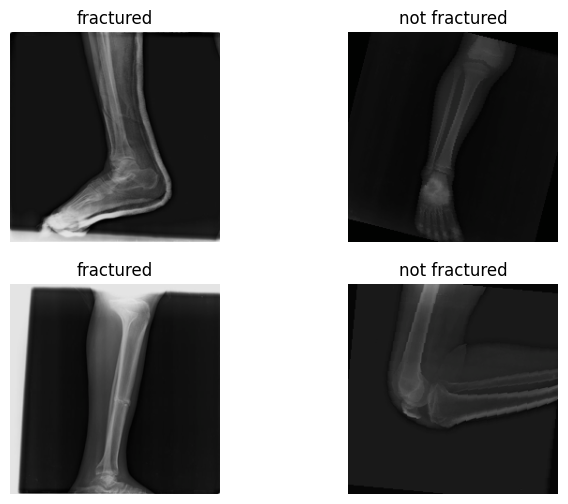

In [14]:
# Function to denormalize (undo ImageNet normalization for display)
def denormalize(img_tensor):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std  = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.numpy().transpose((1, 2, 0))   # CHW -> HWC
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Function to show a batch of images
def show_batch(dataloader, dataset, n=6):
    images, labels = next(iter(dataloader))
    class_names = dataset.dataset.classes  # ['fractured', 'not fractured']

    plt.figure(figsize=(8, 6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        img = denormalize(images[i].cpu())
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# show some training images
show_batch(dl_train, train_dataset, n=4)

Train the model

In [15]:
# -------------------------
# Load Pretrained Model
# -------------------------
import Meansparse_wrn_94_16
from Meansparse_wrn_94_16 import MeanSparse_DMWideResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretrained = MeanSparse_DMWideResNet(
    num_classes=10,
    depth=94,
    width=16,
    activation_fn=nn.SiLU,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2471, 0.2435, 0.2616)
)

checkpoint_path = "/kaggle/working/xAI/Bartoldson2024Adversarial_WRN-94-16_WS.pt"
ckpt = torch.load(checkpoint_path, map_location='cpu')

# Remove old classifier if class count differs
for k in list(ckpt.keys()):
    if k.startswith("logits."):
        del ckpt[k]

missing, unexpected = model_pretrained.load_state_dict(ckpt, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

Missing keys: ['logits.weight', 'logits.bias']
Unexpected keys: []


In [16]:
# Freeze pretrained backbone
for name, param in model_pretrained.named_parameters():
    if not name.startswith("logits"):
        param.requires_grad = False

# Replace final classifier (2-way output)
in_features = model_pretrained.logits.in_features
model_pretrained.logits = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

model = model_pretrained.to(device)

In [17]:
# -------------------------
# Optional: check output shape
# -------------------------
dummy_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    out = model(dummy_input)
print("Output shape for batch size 2:", out.shape)  # should be [2, 2]

Output shape for batch size 2: torch.Size([2, 2])


In [18]:
# -------------------------
# Handle Class Imbalance
# -------------------------
# (Handled by oversampling, no need for loss weights)
criterion = nn.CrossEntropyLoss()

# -------------------------
# Optimizer
# -------------------------
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [19]:
# -------------------------
# Training Loop with Best Model Saving
# -------------------------
def train_model(model, criterion, optimizer, num_epochs=15, save_path="best_meansparse.pth", patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        stop_training = False

        # Each epoch has training + validation
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = dl_train
            else:
                model.eval()
                dataloader = dl_val

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            it = tqdm(dataloader, desc=f"{phase} Epoch {epoch+1}/{num_epochs}")

            for inputs, labels in dataloader:
                # Ensure inputs are on the same device as the model
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                # Update tqdm postfix with current loss and acc
                it.set_postfix(loss=(running_loss/total_samples),
                               acc=(running_corrects.double()/total_samples))

                it.update(1)

            it.close()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Check for improvement
            if phase == "val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, save_path)
                    print(f"✅ Best model updated and saved at {save_path}")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)")

                # Early stopping
                if epochs_no_improve >= patience:
                    print(f"⏹️ Early stopping triggered (no improvement for {patience} epochs).")
                    stop_training = True

        if stop_training:
            break

    print(f"\nBest val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [20]:
# -------------------------
# Model summary
# -------------------------
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
        MeanSparse-3         [-1, 16, 224, 224]               0
              SiLU-4         [-1, 16, 224, 224]               0
            Conv2d-5        [-1, 256, 224, 224]          36,864
       BatchNorm2d-6        [-1, 256, 224, 224]             512
        MeanSparse-7        [-1, 256, 224, 224]               0
              SiLU-8        [-1, 256, 224, 224]               0
            Conv2d-9        [-1, 256, 224, 224]         589,824
           Conv2d-10        [-1, 256, 224, 224]           4,096
       MeanSparse-11        [-1, 256, 224, 224]               0
           _Block-12        [-1, 256, 224, 224]               0
      BatchNorm2d-13        [-1, 256, 224, 224]             512
       MeanSparse-14        [-1, 256, 2

In [21]:
# -------------------------
# Run Training
# -------------------------
trained_model = train_model(model, criterion, optimizer, num_epochs=15, patience=3)


Epoch 1/15


train Epoch 1/15: 100%|██████████| 222/222 [14:50<00:00,  4.01s/it, acc=tensor(0.7834, device='cuda:0', dtype=torch.float64), loss=0.462]


train Loss: 0.4618 Acc: 0.7834


val Epoch 1/15: 100%|██████████| 28/28 [01:50<00:00,  3.96s/it, acc=tensor(0.8649, device='cuda:0', dtype=torch.float64), loss=0.352]


val Loss: 0.3522 Acc: 0.8649
✅ Best model updated and saved at best_meansparse.pth

Epoch 2/15


train Epoch 2/15: 100%|██████████| 222/222 [14:56<00:00,  4.04s/it, acc=tensor(0.8223, device='cuda:0', dtype=torch.float64), loss=0.4]  


train Loss: 0.3996 Acc: 0.8223


val Epoch 2/15: 100%|██████████| 28/28 [01:51<00:00,  3.97s/it, acc=tensor(0.8649, device='cuda:0', dtype=torch.float64), loss=0.383]


val Loss: 0.3832 Acc: 0.8649
⚠️ No improvement for 1 epoch(s)

Epoch 3/15


train Epoch 3/15: 100%|██████████| 222/222 [14:55<00:00,  4.04s/it, acc=tensor(0.8404, device='cuda:0', dtype=torch.float64), loss=0.374]


train Loss: 0.3740 Acc: 0.8404


val Epoch 3/15: 100%|██████████| 28/28 [01:51<00:00,  3.97s/it, acc=tensor(0.8243, device='cuda:0', dtype=torch.float64), loss=0.362]


val Loss: 0.3624 Acc: 0.8243
⚠️ No improvement for 2 epoch(s)

Epoch 4/15


train Epoch 4/15: 100%|██████████| 222/222 [14:56<00:00,  4.04s/it, acc=tensor(0.8398, device='cuda:0', dtype=torch.float64), loss=0.375]


train Loss: 0.3755 Acc: 0.8398


val Epoch 4/15: 100%|██████████| 28/28 [01:51<00:00,  3.97s/it, acc=tensor(0.8739, device='cuda:0', dtype=torch.float64), loss=0.319]


val Loss: 0.3191 Acc: 0.8739
✅ Best model updated and saved at best_meansparse.pth

Epoch 5/15


train Epoch 5/15: 100%|██████████| 222/222 [14:59<00:00,  4.05s/it, acc=tensor(0.8517, device='cuda:0', dtype=torch.float64), loss=0.348]


train Loss: 0.3477 Acc: 0.8517


val Epoch 5/15: 100%|██████████| 28/28 [01:51<00:00,  3.97s/it, acc=tensor(0.9324, device='cuda:0', dtype=torch.float64), loss=0.201]


val Loss: 0.2012 Acc: 0.9324
✅ Best model updated and saved at best_meansparse.pth

Epoch 6/15


train Epoch 6/15: 100%|██████████| 222/222 [14:56<00:00,  4.04s/it, acc=tensor(0.8483, device='cuda:0', dtype=torch.float64), loss=0.358]


train Loss: 0.3583 Acc: 0.8483


val Epoch 6/15: 100%|██████████| 28/28 [01:50<00:00,  3.96s/it, acc=tensor(0.8829, device='cuda:0', dtype=torch.float64), loss=0.277]


val Loss: 0.2772 Acc: 0.8829
⚠️ No improvement for 1 epoch(s)

Epoch 7/15


train Epoch 7/15: 100%|██████████| 222/222 [14:54<00:00,  4.03s/it, acc=tensor(0.8658, device='cuda:0', dtype=torch.float64), loss=0.325]


train Loss: 0.3255 Acc: 0.8658


val Epoch 7/15: 100%|██████████| 28/28 [01:50<00:00,  3.96s/it, acc=tensor(0.8018, device='cuda:0', dtype=torch.float64), loss=0.561]


val Loss: 0.5606 Acc: 0.8018
⚠️ No improvement for 2 epoch(s)

Epoch 8/15


train Epoch 8/15: 100%|██████████| 222/222 [14:53<00:00,  4.03s/it, acc=tensor(0.8652, device='cuda:0', dtype=torch.float64), loss=0.324]


train Loss: 0.3239 Acc: 0.8652


val Epoch 8/15: 100%|██████████| 28/28 [01:51<00:00,  3.97s/it, acc=tensor(0.9324, device='cuda:0', dtype=torch.float64), loss=0.232]

val Loss: 0.2321 Acc: 0.9324
⚠️ No improvement for 3 epoch(s)
⏹️ Early stopping triggered (no improvement for 3 epochs).

Best val Acc: 0.9324


In [23]:
# -------------------------
# Upload the best model to huggingface
# -------------------------
# Install huggingface_hub
!pip install -q huggingface_hub

from huggingface_hub import HfApi, login, create_repo
from kaggle_secrets import UserSecretsClient
import os

# Get token and login
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
login(token=hf_token)
print("✅ Logged in to Hugging Face")

# Create the repository first (only needed once)
repo_id = "MohammadFazli/xAI-fracture-xray-model"
try:
    create_repo(
        repo_id=repo_id,
        token=hf_token,
        private=False,  # Set to True if you want a private repo
        repo_type="model"
    )
    print(f"✅ Repository created: {repo_id}")
except Exception as e:
    print(f"ℹ️  Repository might already exist: {e}")

# Save model (uncomment if not already saved)
local_path = "/kaggle/working/xAI/best_meansparse.pth"
# torch.save(model.state_dict(), local_path)

# Verify file exists
if not os.path.exists(local_path):
    raise FileNotFoundError(f"Model file not found at: {local_path}")
else:
    file_size = os.path.getsize(local_path) / (1024 * 1024)  # MB
    print(f"✅ Model file found: {file_size:.2f} MB")

# Upload to Hugging Face
print("📤 Uploading to Hugging Face...")
api = HfApi()
api.upload_file(
    path_or_fileobj=local_path,
    path_in_repo="best_meansparse_v2.pth",
    repo_id=repo_id,
    repo_type="model",
    token=hf_token
)

print("✅ Model uploaded to Hugging Face Hub!")
print(f"🔗 Access at: https://huggingface.co/{repo_id}")

✅ Logged in to Hugging Face
ℹ️  Repository might already exist: Client error '409 Conflict' for url 'https://huggingface.co/api/repos/create' (Request ID: Root=1-68e660a7-42f742a8443c2776410e7748;e7919e10-bde9-4160-96b2-a597f8a1b9d6)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/409

You already created this model repo
✅ Model file found: 1399.27 MB
📤 Uploading to Hugging Face...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Model uploaded to Hugging Face Hub!
🔗 Access at: https://huggingface.co/MohammadFazli/xAI-fracture-xray-model


Evaluation

In [16]:
# Recreate the model structure exactly as during training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MeanSparse_DMWideResNet(
    num_classes=2,
    depth=94,
    width=16,
    activation_fn=nn.SiLU,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2471, 0.2435, 0.2616)
)

# Freeze backbone and rebuild the classifier head (must match training)
for name, param in model.named_parameters():
    if not name.startswith("logits"):
        param.requires_grad = False

in_features = model.logits.in_features
model.logits = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

# Load trained weights
checkpoint_path = hf_hub_download(
    repo_id="MohammadFazli/xAI-fracture-xray-model",
    filename="best_meansparse_v2.pth"
)
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=True)

model = model.to(device)
model.eval()

print("✅ Model successfully loaded and ready for inference.")

best_meansparse_v2.pth:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

✅ Model successfully loaded and ready for inference.


In [32]:
# -------------------------
# Run evaluation on test set
# -------------------------
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in dl_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


✅ Test Accuracy: 0.9369

🔹 Classification Report:
               precision    recall  f1-score   support

    fractured     0.8816    0.9306    0.9054        72
not fractured     0.9658    0.9400    0.9527       150

     accuracy                         0.9369       222
    macro avg     0.9237    0.9353    0.9291       222
 weighted avg     0.9385    0.9369    0.9374       222



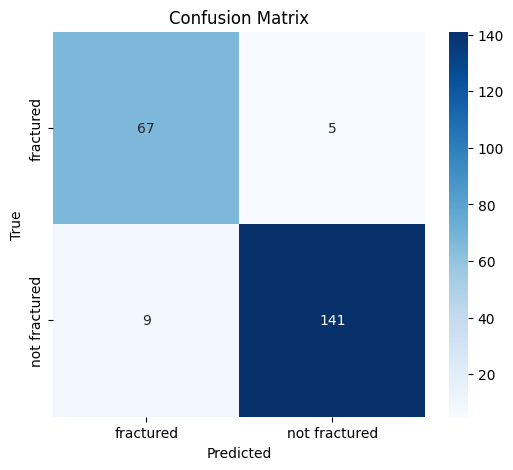

In [34]:
# -------------------------
# Metrics
# -------------------------
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {acc:.4f}\n")

print("🔹 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["fractured", "not fractured"], digits=4))

# -------------------------
# 5. Confusion Matrix
# -------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["fractured", "not fractured"],
            yticklabels=["fractured", "not fractured"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Attack

In [35]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [36]:
eps = 4/255.0        # L_inf epsilon
alpha = 1/255.0      # step size
steps = 10            # PGD steps
random_start = True  # random init inside L_inf ball

# CIFAR-10 normalization statistics (what your model expects)
CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
CIFAR_STD = torch.tensor([0.2470, 0.2435, 0.2616])

# ---------- Helpers ----------
def _maybe_repeat_to_three(x):
    """If input has 1 channel, repeat to 3 channels (model expects 3)."""
    if x.dim() == 4 and x.size(1) == 1:
        return x.repeat(1, 3, 1, 1)
    return x

def pgd_linf_batch_simple(model, x_orig, y, eps, alpha, steps, random_start=True):
    """
    PGD attack for normalized images.
    x_orig: [B,C,H,W] - NORMALIZED images (using CIFAR-10 normalization)
    y: [B] long labels
    returns x_adv: adversarial examples in normalized space
    """
    device = x_orig.device
    
    # Get normalization parameters
    mean = CIFAR_MEAN.view(1, 3, 1, 1).to(device)
    std = CIFAR_STD.view(1, 3, 1, 1).to(device)
    
    # Calculate valid range in normalized space
    # (0 - mean) / std  to  (1 - mean) / std
    lower_limit = (0 - mean) / std
    upper_limit = (1 - mean) / std
    
    # Handle single-channel images
    if x_orig.size(1) == 1:
        lower_limit = lower_limit[:, 0:1, :, :]
        upper_limit = upper_limit[:, 0:1, :, :]
    
    x_orig = x_orig.detach()
    
    if random_start:
        x_adv = x_orig + torch.empty_like(x_orig).uniform_(-eps, eps)
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    else:
        x_adv = x_orig.clone().detach()
    
    loss_fn = nn.CrossEntropyLoss()
    
    for _ in range(steps):
        x_adv.requires_grad_()
        xin = _maybe_repeat_to_three(x_adv)
        logits = model(xin)
        loss = loss_fn(logits, y)
        
        model.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.data.zero_()
        loss.backward()
        
        grad = x_adv.grad.detach()
        x_adv = x_adv.detach() + alpha * torch.sign(grad)
        
        # Project to L_inf ball around original
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        
        # Clamp to valid normalized range (not [0,1]!)
        x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
    
    return x_adv.detach()

In [37]:
def denormalize(img_tensor):
    """
    Denormalize image tensor using dataset mean/std (ImageNet or your dataset)
    img_tensor: [C,H,W] in torch tensor
    returns: [H,W,C] numpy in [0,1]
    """
    mean = np.array([0.4914, 0.4822, 0.4465])
    std  = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.numpy().transpose((1,2,0))  # CHW -> HWC
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_before_after(orig_batch, adv_batch, y_true, y_pred, class_names=None, n=6, figsize_per_img=(3,3)):
    """
    Display original, adversarial, and perturbation images in three rows.
    - orig_batch, adv_batch: torch tensors [B, C, H, W] in normalized form
    - y_true, y_pred: arrays/lists of labels (numeric)
    - class_names: list of class names (index -> name). If None, numeric labels are used.
    - n: number of samples to show (from start of batch)
    - figsize_per_img: tuple (width, height) in inches per image
    """
    # Convert to numpy
    if isinstance(orig_batch, torch.Tensor):
        orig = orig_batch.cpu().numpy()
    else:
        orig = np.array(orig_batch)
    if isinstance(adv_batch, torch.Tensor):
        adv = adv_batch.cpu().numpy()
    else:
        adv = np.array(adv_batch)

    B = orig.shape[0]
    n = min(n, B)
    w, h = figsize_per_img
    plt.figure(figsize=(n * w, h * 3))  # 3 rows, n columns

    for i in range(n):
        # --- Original (top row) ---
        ax = plt.subplot(3, n, i + 1)
        img_o = denormalize(torch.tensor(orig[i]))
        ax.imshow(img_o)
        true_label = (class_names[y_true[i]] if class_names is not None else str(y_true[i]))
        ax.set_title(f"Orig (t={true_label})", fontsize=10)
        ax.axis("off")

        # --- Adversarial (middle row) ---
        ax = plt.subplot(3, n, n + i + 1)
        img_a = denormalize(torch.tensor(adv[i]))
        ax.imshow(img_a)
        pred_label = (class_names[y_pred[i]] if class_names is not None else str(y_pred[i]))
        ax.set_title(f"Adv (p={pred_label})", fontsize=10)
        ax.axis("off")

        # --- Perturbation (bottom row) ---
        pert = img_a - img_o
        pert_min, pert_max = pert.min(), pert.max()
        pert_vis = np.where(pert_max != pert_min,
                            (pert - pert_min) / (pert_max - pert_min),
                            0.5)
        ax2 = plt.subplot(3, n, 2 * n + i + 1)
        ax2.imshow(pert_vis)
        ax2.set_title("Perturbation (Scaled)", fontsize=10)
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

In [38]:
# ---------- Run attack on dl_test and collect preds/labels ----------
model.eval()

all_adv_preds = []
all_adv_labels = []

for inputs, labels in tqdm(dl_test, desc=f"PGD eps={eps} steps={steps}"):
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)

    # Make adversarial examples for this batch
    x_adv = pgd_linf_batch_simple(model, inputs, labels, eps=eps, alpha=alpha, steps=steps, random_start=random_start)

    # Evaluate on adversarial examples
    with torch.no_grad():
        logits_adv = model(_maybe_repeat_to_three(x_adv))
        preds_adv = torch.argmax(logits_adv, dim=1)

    all_adv_preds.append(preds_adv.cpu().numpy())
    all_adv_labels.append(labels.cpu().numpy())

    del inputs, labels, x_adv, logits_adv, preds_adv
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Concatenate results
all_adv_preds = np.concatenate(all_adv_preds)
all_adv_labels = np.concatenate(all_adv_labels)

PGD eps=0.01568627450980392 steps=10: 100%|██████████| 222/222 [38:21<00:00, 10.37s/it]



=== Adversarial test set metrics (PGD L_inf eps=0.01568627450980392, steps=10) ===
Accuracy: 0.5631

Classification report (per-class + macro & weighted):
               precision    recall  f1-score   support

    fractured     0.3656    0.4722    0.4121        72
not fractured     0.7054    0.6067    0.6523       150

     accuracy                         0.5631       222
    macro avg     0.5355    0.5394    0.5322       222
 weighted avg     0.5952    0.5631    0.5744       222


Confusion matrix (rows=true, cols=pred):
[[34 38]
 [59 91]]


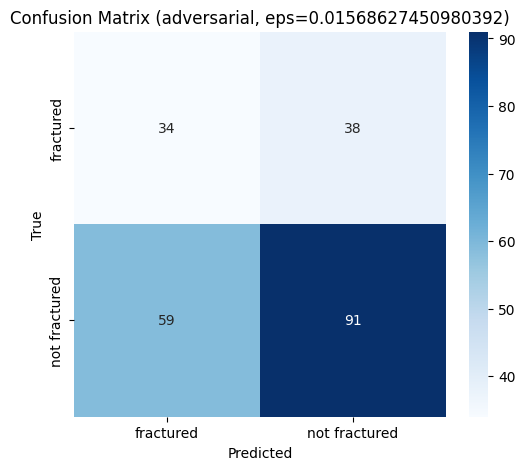


Macro-avg: precision=0.5355, recall=0.5394, f1=0.5322
Weighted-avg: precision=0.5952, recall=0.5631, f1=0.5744


In [39]:
# ---------- Compute & print metrics ----------
class_names = train_dataset.dataset.classes if hasattr(train_dataset, "dataset") else ['fractured', 'not fractured']
acc = accuracy_score(all_adv_labels, all_adv_preds)
report_dict = classification_report(all_adv_labels, all_adv_preds, target_names=class_names, digits=4, output_dict=True)
report_str = classification_report(all_adv_labels, all_adv_preds, target_names=class_names, digits=4)
cm = confusion_matrix(all_adv_labels, all_adv_preds)

print(f"\n=== Adversarial test set metrics (PGD L_inf eps={eps}, steps={steps}) ===")
print(f"Accuracy: {acc:.4f}\n")
print("Classification report (per-class + macro & weighted):")
print(report_str)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

# Confusion heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (adversarial, eps={eps})")
plt.show()

# Macro & weighted scores
macro_p = report_dict['macro avg']['precision']
macro_r = report_dict['macro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']
w_p = report_dict['weighted avg']['precision']
w_r = report_dict['weighted avg']['recall']
w_f1 = report_dict['weighted avg']['f1-score']

print(f"\nMacro-avg: precision={macro_p:.4f}, recall={macro_r:.4f}, f1={macro_f1:.4f}")
print(f"Weighted-avg: precision={w_p:.4f}, recall={w_r:.4f}, f1={w_f1:.4f}")

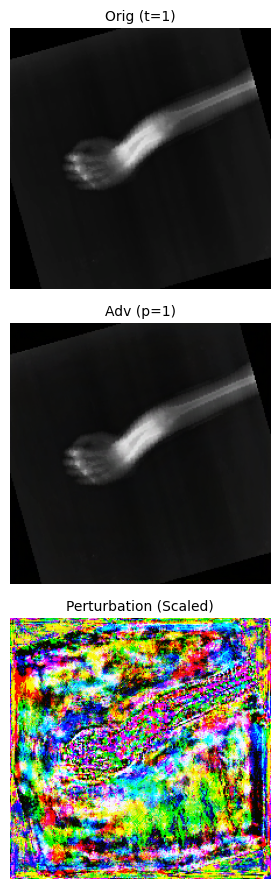

In [40]:
# -------------------------
# Example usage with one batch
# -------------------------
# get one small batch
inputs, labels = next(iter(dl_test))
# create adversarial batch (small n, e.g. steps=1)
x_adv = pgd_linf_batch_simple(model, inputs.to(device), labels.to(device), eps=eps, alpha=alpha, steps=steps, random_start=random_start)
with torch.no_grad():
    logits_adv = model(_maybe_repeat_to_three(x_adv))
    preds = torch.argmax(logits_adv, dim=1).cpu().numpy()

# choose class names from test dataset if available
class_names = test_dataset.classes if hasattr(test_dataset, "classes") else None

# show first 6 examples (or change n)
show_before_after(inputs, x_adv.cpu(), labels.numpy(), preds, class_names=class_names, n=6, figsize_per_img=(3.0, 3.0))